# Imports

In [1]:
import numpy as np
import pandas as pd
import os

from skimage.transform import resize   # Image Processing Library
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc    # Garbage Collector
gc.collect()

import random

import os

# Pytorch

import torch
import torchvision

from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange

In [2]:
# Input data files (dogs_and_cats) are available in the "../data/dogs_and_cats/" directory.
print(os.listdir("../data/dogs_and_cats"))

['annotations', 'images']


# Data Preprocessing

In [3]:
img_dir = "../data/dogs_and_cats/images/"
annotations_dir = "../data/dogs_and_cats/annotations/"

In [4]:
img_dir

'../data/dogs_and_cats/images/'

In [5]:
os.listdir(img_dir)[0]

'Abyssinian_1.jpg'

In [6]:
img_path = os.path.join(img_dir, os.listdir(img_dir)[0])
img_path

'../data/dogs_and_cats/images/Abyssinian_1.jpg'

In [7]:
test_image = read_image(img_path)

In [8]:
test_image.shape

torch.Size([3, 128, 128])

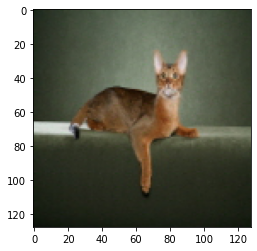

In [9]:
plt.imshow(test_image.permute(1, 2, 0));

In [10]:
# Class for Datasets using Custom Images

class CustomImageDataset(Dataset):
    def __init__(self, annotations_dir, img_dir, transform=None, target_transform=None):
        self.annotations_dir = annotations_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, os.listdir(self.img_dir)[idx])
        image = read_image(img_path)
        annotation_path = os.path.join(self.annotations_dir, os.listdir(self.annotations_dir)[idx])
        annotation = read_image(annotation_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            annotation = self.target_transform(annotation)
        return image, annotation

In [11]:
dataset = CustomImageDataset(
    annotations_dir, 
    img_dir,
    # transform=ToTensor(),          -> Gives Error
    # target_transform=ToTensor()    -> Gives Error
)

In [12]:
test_img, test_annot = dataset[0]

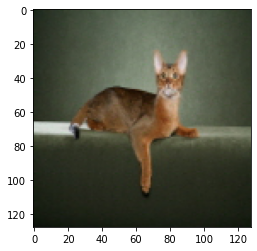

In [13]:
plt.imshow(test_img.permute(1, 2, 0));

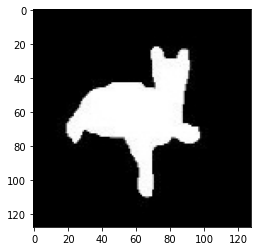

In [14]:
plt.imshow(test_annot.permute(1, 2, 0));

In [15]:
len(dataset)

7390

# Preparation of Train / Test DataLoader

In [16]:
BATCH_SIZE = 10
VALIDATION_SPLIT = 0.2
SHUFFLE_DATASET = True
RANDOM_SEED = 42

In [17]:
# Creating data indices for training and validation splits:

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(VALIDATION_SPLIT * dataset_size))
if SHUFFLE_DATASET :
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, 
                          sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=BATCH_SIZE,
                               sampler=valid_sampler)

In [18]:
# Sample Image and Annotation

sample_img, sample_annot = next(iter(train_loader))

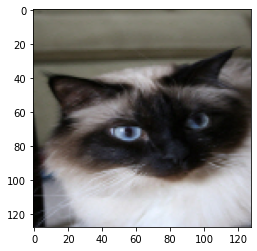

In [19]:
plt.imshow(sample_img[0].squeeze().permute(1, 2, 0));

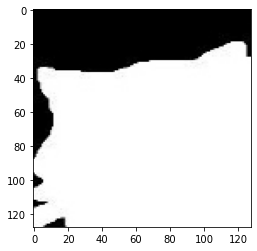

In [20]:
plt.imshow(sample_annot[0].squeeze().permute(1, 2, 0));

# Unet Setup

In [ ]:
use_gpu = torch.cuda.is_available()

In [ ]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels)
        )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.ConvTranspose2d(in_channels=mid_channel, 
                                     out_channels=out_channels, 
                                     kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        return block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels)
        )
        return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(512),
            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(512),
            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2   # Calculate by how much the bypass should be decreased
            bypass = F.pad(bypass, (-c, -c, -c, -c))   # Reduces the bypass by padding -c
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        ##print(x.shape, encode_block1.shape, encode_block2.shape, encode_block3.shape, bottleneck1.shape)
        ##print('Decode Block 3')
        ##print(bottleneck1.shape, encode_block3.shape)
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        ##print(decode_block3.shape)
        ##print('Decode Block 2')
        cat_layer2 = self.conv_decode3(decode_block3)
        ##print(cat_layer2.shape, encode_block2.shape)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        ##print(cat_layer1.shape, encode_block1.shape)
        ##print('Final Layer')
        ##print(cat_layer1.shape, encode_block1.shape)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        ##print(decode_block1.shape)
        final_layer = self.final_layer(decode_block1)
        ##print(final_layer.shape)
        return  final_layer

# Model Training

In [ ]:
learning_rate = 0.01
unet = UNet(in_channel=1, out_channel=2)
if use_gpu:
    unet = unet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unet.parameters(), lr=learning_rate, momentum=0.99)

In [ ]:
def train_step(inputs, labels, optimizer, criterion):
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = unet(inputs)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(batch_size*width_out*height_out, 2)  
    labels = labels.resize(batch_size*width_out*height_out)   # Resize to 1D
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
def get_val_loss(x_val, y_val):
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = unet(x_val)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = y_val.resize(m*width_out*height_out)
    loss = F.cross_entropy(outputs, labels)
    return loss.data

In [ ]:
batch_size = 9
epochs = 1000
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [ ]:
epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)  # Calculate # of iteration based on batch size
t = trange(epochs, leave=True)   # leave=True : leaves progress bar upon termination of iteration
for _ in t:
    total_loss = 0
    for i in range(epoch_iter):
        batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
        batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        if use_gpu:
            batch_train_x = batch_train_x.cuda()
            batch_train_y = batch_train_y.cuda()
        batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion)
        total_loss += batch_loss
    if (_+1) % epoch_lapse == 0:
        val_loss = get_val_loss(x_val, y_val)
        print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss}")

In [ ]:
gc.collect()

# Evaluation

In [ ]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.transpose(image_arr, (1,2,0))[:,:,0])
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow(image_arr.argmax(0))
        ax[row_num][2].set_title("Segmented Image localization")
        ax[row_num][3].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][3].set_title("Target image")
    plt.show()

In [ ]:
plot_examples(x_train, y_train)

In [ ]:
plot_examples(x_val, y_val)

In [ ]:
torch.save(unet.state_dict(), 'unet.pt')